In [53]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.controller.recorder import TrainRecorder
from torchlake.common.controller.weight_manager import WeightManager
from torchlake.pose_estimation.controller.hourglass.trainer import \
    StackedHourglassTrainer
from torchlake.pose_estimation.datasets.mpii import MPIIFromLMDB, MPII_CLASS_NAMES, MPIIFromJSON, MPIIFromRaw
from torchlake.pose_estimation.models.hourglass import StackedHourglass

In [54]:
import matplotlib.pyplot as plt
from pathlib import Path

In [55]:
torch.__version__

'2.1.0+cu118'

# setting

In [56]:
artifact_path = Path('../../artifacts/hourglass')
artifact_path.mkdir(exist_ok=True)

In [57]:
data_path = Path("../../data/MPII")

In [58]:
DEVICE = torch.device("cuda:0")

# data

In [59]:
BATCH_SIZE = 32

In [60]:
IMAGE_SIZE = 256

In [61]:
transform = A.Compose(
    [
        A.ColorJitter(p=0.3),
        # A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=0.25, rotate_limit=0.3),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        # A.augmentations.geometric.resize.SmallestMaxSize(input_size),
        # A.RandomSizedBBoxSafeCrop(input_size, input_size),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    keypoint_params=A.KeypointParams(
        format="xy",
        remove_invisible=False,
    ),
)

In [62]:
# train_dataset = MPIIFromRaw(
#     data_path,
#     mode="train",
#     crop_by_person=True,
#     transform=transform,
# )

In [63]:
# to get json version
# train_dataset.to_json(data_path.joinpath("annotations.train.json"))

In [64]:
# train_dataset = MPIIFromJSON(
#     data_path,
#     data_path.joinpath("annotations.train.json"),
#     transform=transform,
# )

In [65]:
train_dataset = MPIIFromLMDB(
    "F://data/MPII",
    transform=transform,
)

In [66]:
for i, (x, y) in enumerate(train_dataset):
    print(i, x.shape, y.shape)
    break

0 torch.Size([3, 256, 256]) torch.Size([16, 3])


In [67]:
NUM_CLASS = len(MPII_CLASS_NAMES)

In [68]:
NUM_CLASS

16

In [69]:
# def collate_fn(batch) -> list[torch.Tensor]:
#     imgs, labels = [], []
#     for img, label in batch:
#         imgs.append(img)
#         labels.append(label)
    
#     return torch.cat(imgs), torch.cat(labels)

In [70]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    # for raw, json version use this line
    # lmdb doesn't need
    # collate_fn=collate_fn if train_dataset.crop_by_person else None, 
)

In [71]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([32, 3, 256, 256]) torch.Size([32, 16, 3])


# debug

In [72]:
# from torchlake.pose_estimation.utils.plot import draw_skeleton
# from torchlake.pose_estimation.datasets.mpii.constants import (
#     MPII_CLASS_NAMES,
#     MPII_JOINT_EDGES,
# )
# from torchlake.common.utils.convert import img_tensor_to_np

# img, label = train_dataset[12981]

# print("num person:", len(img))
# person_idx = 0
# copy_img = img_tensor_to_np(img[person_idx])

# person_label = label[person_idx]
# # rect = person_label[person_label[:, 2] == 0][:, :2].int()
# # x1, y1 = rect.min(0).values
# # x2, y2 = rect.max(0).values

# draw_skeleton(
#     copy_img,
#     label[person_idx, :, :2].unsqueeze(0),
#     masks=label[person_idx, :, 2:3].unsqueeze(0),
#     class_names=MPII_CLASS_NAMES,
#     class_edges=MPII_JOINT_EDGES,
#     radius=5,
# )

# plt.figure(figsize=(6, 6))
# plt.imshow(copy_img.clip(0, 1))
# # plt.imshow(copy_img[y1 - 15 : y2 + 15, x1 - 15 : x2 + 15])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


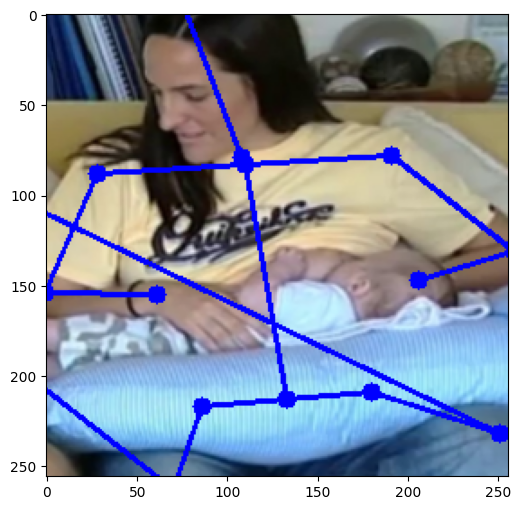

In [73]:
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.pose_estimation.utils.plot import draw_skeleton
from torchlake.pose_estimation.datasets.mpii import MPII_CLASS_NAMES, MPII_JOINT_EDGES

BATCH_IDX = 5
copy_img = img_tensor_to_np(x[BATCH_IDX])
draw_skeleton(
    copy_img,
    y[BATCH_IDX, None, :, :2],
    # y[BATCH_IDX, None, :, 2:3],
    class_names=MPII_CLASS_NAMES,
    class_edges=MPII_JOINT_EDGES,
    radius=5,
)
plt.figure(figsize=(6, 6))
plt.imshow(copy_img)

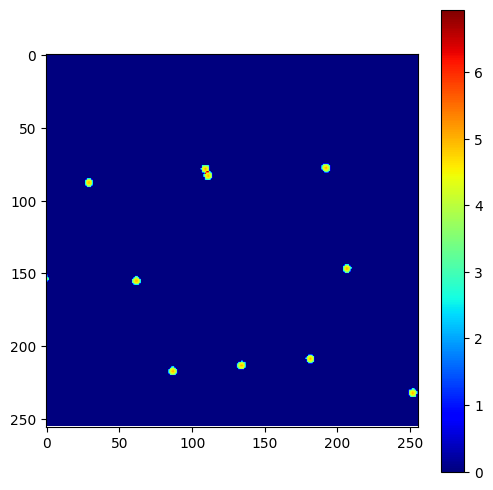

In [74]:
from torchlake.common.utils.numerical import build_gaussian_heatmap

hm = build_gaussian_heatmap(
    y[BATCH_IDX, None, :, :2].flip(-1),
    copy_img.shape[:2],
    sigma=3,
    effective_range=3,
    normalized=False,
    amplitude=5,
).exp()[0]

plt.figure(figsize=(6, 6))
plt.imshow(hm.sum(0).unsqueeze(-1), cmap="jet")
plt.colorbar()

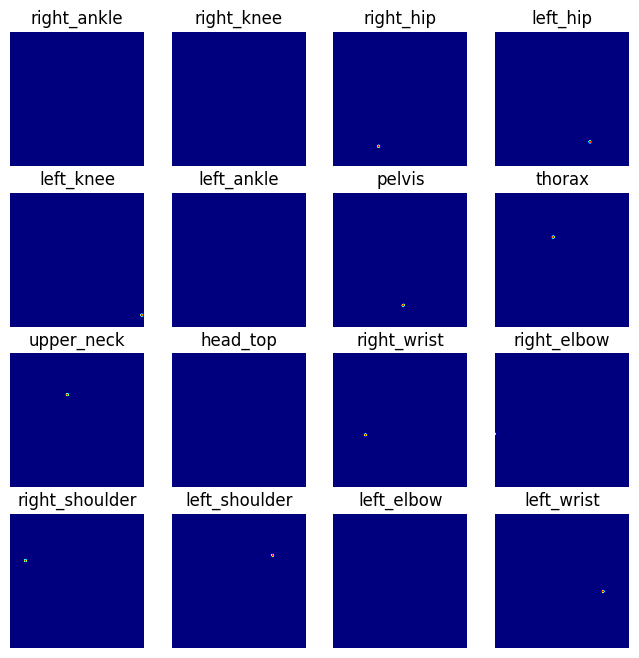

In [75]:
from torchlake.common.utils.plot import plot_grids

plot_grids(
    hm.unsqueeze(-1),
    titles=MPII_CLASS_NAMES,
    num_row=4,
    num_col=4,
    cmap="jet",
)

# model

In [76]:
model = StackedHourglass(output_size=NUM_CLASS, num_stack=4, num_nested=2).to(DEVICE)

In [77]:
torchinfo.summary(model)

Layer (type:depth-idx)                                                 Param #
StackedHourglass                                                       --
├─Sequential: 1-1                                                      --
│    └─Conv2dNormActivation: 2-1                                       --
│    │    └─Conv2d: 3-1                                                9,408
│    │    └─BatchNorm2d: 3-2                                           128
│    │    └─ReLU: 3-3                                                  --
│    └─ResBlock: 2-2                                                   --
│    │    └─ReLU: 3-4                                                  --
│    │    └─BottleNeck: 3-5                                            49,536
│    │    └─Sequential: 3-6                                            8,448
│    └─MaxPool2d: 2-3                                                  --
│    └─ResBlock: 2-4                                                   --
│    │    └─ReLU: 3-7 

# train

In [ ]:
recorder = TrainRecorder(total_epoch=10)
recorder.increment_data_size(len(train_dataset))

In [78]:
trainer = StackedHourglassTrainer(sigma=3, effective_range=3, amplitude=5, device=DEVICE)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss(reduction="sum")

In [ ]:
scaler = torch.cuda.amp.GradScaler()

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [ ]:
_ = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler,
    scaler=scaler,
    recorder=recorder,
)

Enable AMP: True
Training...


100%|██████████| 892/892 [05:31<00:00,  2.69it/s]


------------------------------------
Epoch 1
------------------------------------
65845.29475351871 (0%)


100%|██████████| 892/892 [05:07<00:00,  2.90it/s]


------------------------------------
Epoch 2
------------------------------------
25111.00773755335 (-62%)


100%|██████████| 892/892 [05:08<00:00,  2.90it/s]


------------------------------------
Epoch 3
------------------------------------
24596.44863586235 (-2%)


100%|██████████| 892/892 [05:07<00:00,  2.90it/s]


------------------------------------
Epoch 4
------------------------------------
24041.936541558716 (-2%)


100%|██████████| 892/892 [05:11<00:00,  2.86it/s]


------------------------------------
Epoch 5
------------------------------------
23421.45708021148 (-3%)


100%|██████████| 892/892 [05:11<00:00,  2.86it/s]


------------------------------------
Epoch 6
------------------------------------
22769.887448795605 (-3%)


100%|██████████| 892/892 [05:09<00:00,  2.88it/s]


------------------------------------
Epoch 7
------------------------------------
22132.42679740564 (-3%)


100%|██████████| 892/892 [05:10<00:00,  2.87it/s]


------------------------------------
Epoch 8
------------------------------------
21542.01607030317 (-3%)


100%|██████████| 892/892 [05:09<00:00,  2.88it/s]


------------------------------------
Epoch 9
------------------------------------
21002.63607021569 (-3%)


100%|██████████| 892/892 [05:17<00:00,  2.81it/s]

------------------------------------
Epoch 10
------------------------------------
20541.995767978442 (-2%)


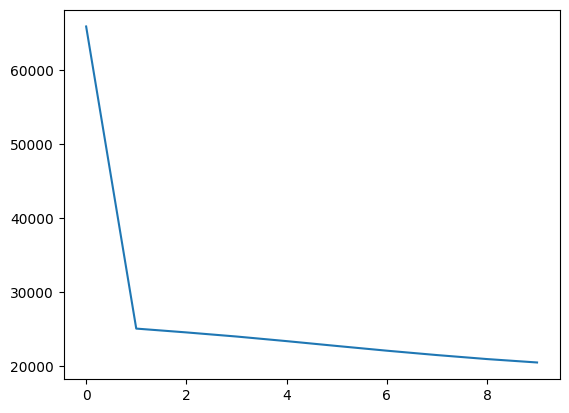

In [ ]:
plt.plot(recorder.training_losses[0])

In [79]:
weight_manager = WeightManager(artifact_path.joinpath("hourglass.mpii.{num_stack}.{num_nested}.sigma.{sigma}.range.{range}.amplitude.{amplitude}.pth").as_posix())

In [80]:
model_path = weight_manager.get_filename(
    num_stack=model.num_stack,
    num_nested=model.num_nested,
    sigma=trainer.sigma,
    range=trainer.effective_range,
    amplitude=trainer.amplitude,
)
model_path

WindowsPath('../../artifacts/hourglass/hourglass.mpii.4.2.sigma.3.range.3.amplitude.5.pth')

In [ ]:
weight_manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\hourglass\hourglass.mpii.4.2.sigma.3.range.3.pth, model size is 30.01MiB


In [81]:
weight_manager.load_weight(model_path, model)

# Inference

In [82]:
import numpy as np
from torchlake.common.utils.image import load_image
from torchlake.common.utils.plot import plot_grids
import torch.nn.functional as F

In [83]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [132]:
image = load_image("../../data/coco/val2017/000000009448.jpg", is_numpy=True)
image = load_image("../../data/coco/train2017/000000000436.jpg", is_numpy=True)
image = load_image("../../data/coco/train2017/000000000474.jpg", is_numpy=True)


In [133]:
# x = train_dataset[100][0]
x = test_transform(image=image)["image"]

In [134]:
pred = model(x[None, ...].to(DEVICE))[:, -1].detach().cpu()
# pred = (model(x[None, ...].to(DEVICE))[:, -1] + model(x[None, ...].flip(-1).to(DEVICE))[:, -1].flip(-1)).div(2).detach().cpu()

In [135]:
# smooth heatmap
# from torch import nn
# pool = nn.MaxPool2d(3, 1, padding=1)
# from torchvision.transforms import GaussianBlur
# pool = GaussianBlur(kernel_size=5, sigma=(2, 2))

In [136]:
heatmap = F.interpolate(pred.float(), size=x.shape[1:])[0].numpy()
# heatmap = F.interpolate(pool(pred.float()), size=x.shape[1:])[0].numpy()
# heatmap = pred.float()[0].numpy()

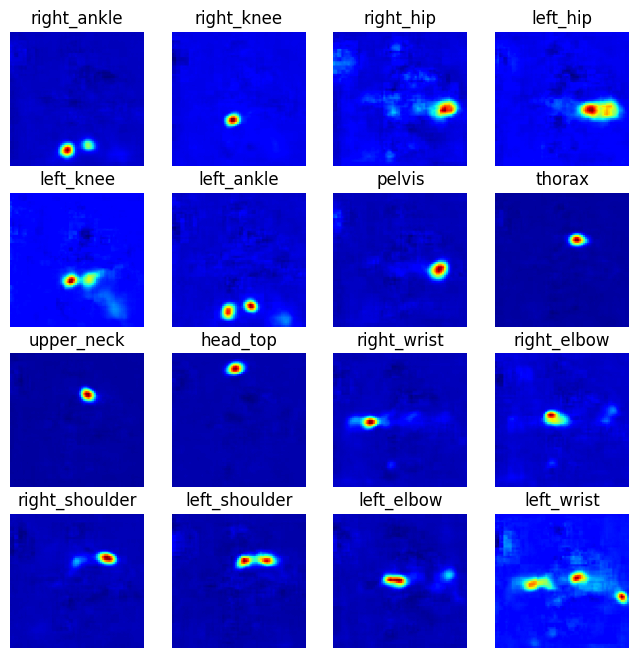

In [137]:
plot_grids(
    heatmap,
    titles=MPII_CLASS_NAMES,
    num_row=4,
    num_col=4,
    # is_gray_scale=True,
    cmap="jet",
)

In [138]:
keypoints = np.column_stack(
    np.unravel_index(
        heatmap.reshape(16, -1).argmax(-1),
        heatmap.shape[1:],
    )
)

In [139]:
keypoints

array([[224, 108],
       [168, 112],
       [148, 212],
       [148, 184],
       [168, 112],
       [212, 148],
       [144, 200],
       [ 88, 156],
       [ 76, 148],
       [ 28, 120],
       [132,  68],
       [116, 104],
       [ 80, 184],
       [ 88, 136],
       [124, 124],
       [156, 240]], dtype=int64)

In [140]:
from torchlake.common.utils.image import overlay_image
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.pose_estimation.utils.plot import draw_skeleton

In [141]:
copy_img = img_tensor_to_np(x)
draw_skeleton(
    copy_img,
    # keypoints[None, ...],
    np.flip(keypoints[None, ...], axis=-1),
    class_names=MPII_CLASS_NAMES,
    class_edges=MPII_JOINT_EDGES,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


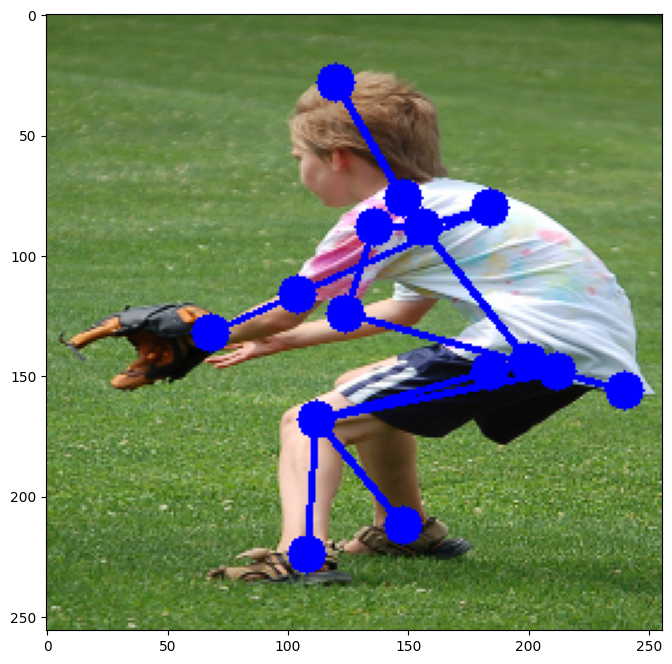

In [142]:
plt.figure(figsize=(8,8))
plt.imshow(copy_img)

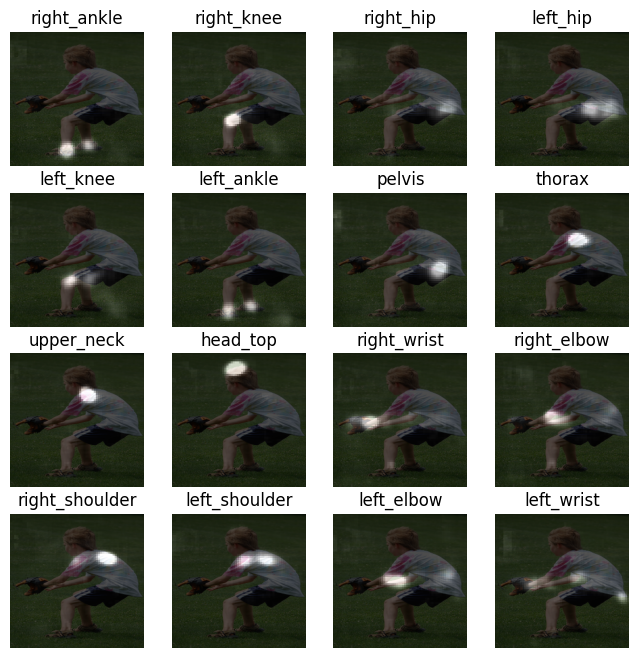

In [143]:
plot_grids(
    [
        overlay_image(img_tensor_to_np(x), np.repeat(hm[:,:, None], 3, axis=-1).clip(0, 1), 0.7) 
        for hm in heatmap
    ],
    titles=MPII_CLASS_NAMES,
    num_row=4,
    num_col=4,
    cmap="jet",
)

# evaluation

## train accuracy

In [30]:
val_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    keypoint_params=A.KeypointParams(
        format="xy",
        remove_invisible=False,
    ),
)

In [31]:
val_dataset = MPIIFromLMDB(
    "F://data/MPII",
    transform=val_transform,
)

In [ ]:
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    # num_workers=get_num_workers(),
    # for raw, json version use this line
    # lmdb doesn't need
    # collate_fn=collate_fn if train_dataset.crop_by_person else None, 
)

In [33]:
from torchlake.pose_estimation.controller.hourglass.evaluator import PoseEstimationEvaluator
from torchlake.pose_estimation.metrics import PCK

In [34]:
evaluator = PoseEstimationEvaluator(NUM_CLASS, DEVICE)

In [39]:
metric = PCK(NUM_CLASS, threshold=IMAGE_SIZE * 0.05)

In [40]:
evaluator.run(val_loader, model, metric)

100%|██████████| 893/893 [04:24<00:00,  3.38it/s]

In [51]:
for class_name, acc in zip(MPII_CLASS_NAMES, metric.hits):
    print(f"{class_name}: {(acc[0] / acc.sum()).item():.2f}")

right_ankle: 0.01
right_knee: 0.02
right_hip: 0.03
left_hip: 0.06
left_knee: 0.04
left_ankle: 0.01
pelvis: 0.10
thorax: 0.04
upper_neck: 0.03
head_top: 0.02
right_wrist: 0.02
right_elbow: 0.03
right_shoulder: 0.09
left_shoulder: 0.03
left_elbow: 0.02
left_wrist: 0.03
